In [8]:
#librerías de sistema y manejo de datos
import os
import numpy as np
import pandas as pd

#visualización
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

#procesamiento de imágenes
from PIL import Image
import cv2

#modelado
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.utils.class_weight import compute_class_weight
import keras.backend as K

#web app
import streamlit as st

#importación de datasets
from kaggle.api.kaggle_api_extended import KaggleApi

In [3]:
#crear ruta para el dataset

base_dir = os.path.join('../data/raw/waste_classification')

#lista vacía para guardar las imágenes

rows = []

#función para extraer las imágenes y formar el dataframe

for root, dirs, files in os.walk(base_dir):
    for fname in files:
        if fname.lower().endswith(('.jpg', 'jpeg', 'png', 'bmp', 'gif')):
            rel_dir = os.path.relpath(root, base_dir)
            parts = rel_dir.split(os.sep)
            class_name = parts[0]
            subclass = None
            for part in parts[1:]:
                if part and part != class_name:
                    subclass = part
                    break
            if subclass is None:
                subclass = class_name
            file_path = os.path.join(rel_dir, fname)
            rows.append({
                'file_name': file_path,
                'label': class_name,
                'subclass': subclass
            })

labels = pd.DataFrame(rows)

#guardar dataframe como csv

labels.to_csv(os.path.join('..', 'data', 'labels.csv'), index=False)

print(f"Total imágenes indexadas: {len(labels)}")
print(labels[['file_name', 'label', 'subclass']].head())

Total imágenes indexadas: 2902
                                           file_name           label  \
0  Non-Recyclable/Non-Recyclable/ceramic_product/...  Non-Recyclable   
1  Non-Recyclable/Non-Recyclable/ceramic_product/...  Non-Recyclable   
2  Non-Recyclable/Non-Recyclable/ceramic_product/...  Non-Recyclable   
3  Non-Recyclable/Non-Recyclable/ceramic_product/...  Non-Recyclable   
4  Non-Recyclable/Non-Recyclable/ceramic_product/...  Non-Recyclable   

          subclass  
0  ceramic_product  
1  ceramic_product  
2  ceramic_product  
3  ceramic_product  
4  ceramic_product  


## EDA

El siguiente EDA se conforma de algunos gráficos donde se busca entender mejor la distribución de las imágenes. 

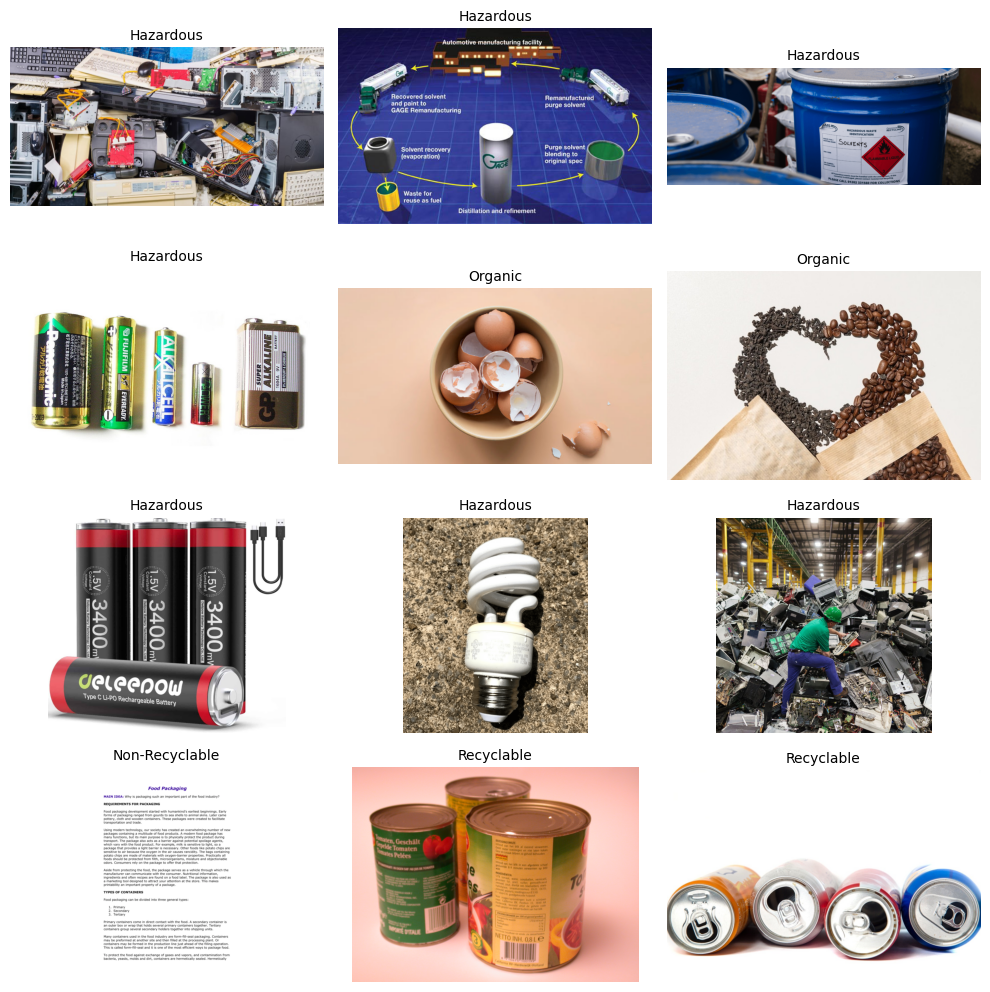

In [ ]:
#tomar 12 muestras aleatorias
sample = labels.sample(n=12, random_state=123).reset_index(drop=True)

#crear gráfico con las muestras
fig, axes = plt.subplots(4, 3, figsize=(10, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    #construir ruta completa a la imagen
    img_path = os.path.join(base_dir, sample.loc[i, 'file_name'])
    img = Image.open(img_path)
    
    ax.imshow(img)  
    ax.set_title(sample.loc[i, 'label'], fontsize=10)  
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#generar un histograma 

histogram = px.histogram(labels['label'])
histogram

In [ ]:
#agrupar y contar por jerarquía

counts = labels.groupby(['label', 'subclass']).size().reset_index(name='count')

#generar listas para elñ treemap

classes = counts['label'].unique().tolist()
class_counts = counts.groupby('label')['count'].sum().reindex(classes).tolist()
subclasses = counts['subclass'].tolist()
parents = [''] * len(classes) + counts['label'].tolist()
values = class_counts + counts['count'].tolist()
labels_list = classes + subclasses

#generar el treemap

fig = go.Figure(go.Treemap(
    labels=labels_list,
    parents=parents,
    values=values,
    branchvalues='total'
))

fig.update_layout(title='Treemap de clases y subclases')
fig.show()

In [ ]:
#verificar errores en las imágenes

errores = []
total   = len(labels)

#verificar la integridad de cada imagen

for idx, row in labels.iterrows():
    img_path = os.path.join(base_dir, row['file_name'])
    try:
        with Image.open(img_path) as img:
            img.verify()    
    except Exception as e:
        errores.append((row['file_name'], str(e)))

#mostrar los errores

buenas = total - len(errores)
print(f'Imágenes válidas: {buenas}')
print(f'Imágenes corruptas o ilegibles: {len(errores)} de {total}')

if errores:
    print('\nPrimeros 5 errores:')
    for ruta, msg in errores[:5]:
        print(f"  • {ruta}: {msg}")

/Users/luistorres/Documents/Proyectos/GreenVisionModel/Vision_ml/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning:

Truncated File Read



Imágenes válidas: 2902
Imágenes corruptas o ilegibles: 0 de 2902


In [ ]:
#verificar tamaños y formatos

props = []

for _, row in labels.iterrows():
    img_path = os.path.join(base_dir, row['file_name'])
    with Image.open(img_path) as img:
        props.append({
            "file_name": row['file_name'],
            "label":     row['label'],
            "format":    img.format,      
            "width":     img.width,
            "height":    img.height
        })

#crear dataFrame con las propiedades
dims_df = pd.DataFrame(props)

#resumen de formatos
print('Formatos de imagen y su conteo:')
print(dims_df['format'].value_counts(), "\n")

#resumen de dimensiones únicas
size_counts = (
    dims_df
    .groupby(['width', 'height'])
    .size()
    .reset_index(name='count')
    .sort_values('count', ascending=False)
)
print('Tamaños de imagen (width × height) y su frecuencia:')
print(size_counts)

Formatos de imagen y su conteo:
format
JPEG    2473
PNG      361
WEBP      47
GIF       18
MPO        3
Name: count, dtype: int64 

Tamaños de imagen (width × height) y su frecuencia:
      width  height  count
1055   1280     720     60
1183   1500    1101     42
1085   1300     956     37
1001   1200     800     31
589     800     534     30
...     ...     ...    ...
579     800     470      1
578     800     466      1
577     800     462      1
574     800     445      1
1543   7800    5200      1

[1544 rows x 3 columns]


In [ ]:
#función para transformar imágenes a RGB y dimensionarlas

def load_and_preprocess_image(path, size=(224, 224)):
 
    img = Image.open(path)
    
    #extraer primer frame si está animada/multipágina
    if getattr(img, "is_animated", False):
        img.seek(0)
    
    #convertir a RGB
    img = img.convert("RGB")
    
    #redimensionar (distorsión simple)
    img = img.resize(size)
    
    return img

In [ ]:
#extraer las clases únicas

classes = np.unique(labels['label'])

#calcular pesos balanceados

weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=labels['label'].values
)

#crear diccionario para Keras

class_weight = dict(zip(classes, weights))

print("Pesos por clase:")
for cls, w in class_weight.items():
    print(f"  • {cls}: {w:.2f}")

Pesos por clase:
  • Hazardous: 0.77
  • Non-Recyclable: 1.13
  • Organic: 1.10
  • Recyclable: 1.11


In [ ]:
#funcion para crear un ImageDataGenerator para entrenamiento
def load_train(data_root, labels_csv='labels.csv', batch_size=32,
               target_size=(224, 224), val_split=0.15, seed=12345):

    #leer manifest de imágenes
    labels_df = pd.read_csv(os.path.join(data_root, labels_csv))

    labels_df = labels_df[
    labels_df['file_name'].apply(
        lambda fp: os.path.exists(os.path.join(data_root, 'raw', 'waste_classification', fp))
    )
].reset_index(drop=True)

    #generador con split
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=val_split
    )

    train_gen = datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=os.path.join(data_root, 'raw', 'waste_classification'),
        x_col='file_name',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        seed=seed,
        shuffle=True
    )
    return train_gen

In [ ]:
#funcion para crear un ImageDataGenerator para validación

def load_validation(data_root, labels_csv='labels.csv', batch_size=32,
                    target_size=(224, 224), val_split=0.15, seed=12345):
    
    labels_df = pd.read_csv(os.path.join(data_root, labels_csv))

    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=val_split
    )

    val_gen = datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=os.path.join(data_root, 'raw', 'waste_classification'),
        x_col='file_name',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        seed=seed,
        shuffle=False
    )
    return val_gen

In [ ]:
#función para  rear un modelo con ResNet50 como backbone

def create_model(input_shape=(224,224,3), num_classes=4, lr=3e-4, dropout_rate=0.2):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    backbone.trainable = False 
    
    model = Sequential([
        backbone,
        Dropout(dropout_rate),
        GlobalAveragePooling2D(),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
#función para entrenar el modelo usando generators y pesos de clase

def train_model(model, train_gen, val_gen,
                epochs=20, class_weight=None,
                callbacks=None):
    
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        class_weight=class_weight,
        callbacks=callbacks,
        verbose=2
    )
    return history

In [ ]:
# 1) Clases según el generador
classes = np.array(list(train_gen.class_indices.keys()))
print("Clases:", classes)

# 2) Pesos “raw” inversamente proporcionales al tamaño de cada clase
raw_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=labels['label'].values
)
raw_class_weight = dict(zip(classes, raw_weights))
print("Pesos por clase (raw):", raw_class_weight)

# 3) Mapeo de índice → peso para Keras
indexed_class_weight = {
    train_gen.class_indices[cls_name]: weight
    for cls_name, weight in raw_class_weight.items()
}
print("Pesos por índice de clase:", indexed_class_weight)

Clases: ['Hazardous' 'Non-Recyclable' 'Organic' 'Recyclable']
Pesos por clase (raw): {np.str_('Hazardous'): np.float64(0.7701698513800425), np.str_('Non-Recyclable'): np.float64(1.1265527950310559), np.str_('Organic'): np.float64(1.0959214501510575), np.str_('Recyclable'): np.float64(1.1093272171253823)}
Pesos por índice de clase: {0: np.float64(0.7701698513800425), 1: np.float64(1.1265527950310559), 2: np.float64(1.0959214501510575), 3: np.float64(1.1093272171253823)}


In [ ]:
train_gen = load_train(data_root, labels_csv='labels.csv')
val_gen   = load_validation(data_root, labels_csv='labels.csv')

# 1) Obtén el mapeo de clase → índice
class_indices = train_gen.class_indices
print("Mapping de clases:", class_indices)

# 2) Cuenta cuántas clases hay
num_classes = len(class_indices)
print("Número de clases detectadas:", num_classes)

# 3) Crea el modelo usando la variable num_classes, NO train_gen.num_classes
model = create_model(
    input_shape=(224, 224, 3),
    num_classes=num_classes
)

# 4) Y entrena con tus pesos ya calculados
history = train_model(
    model,
    train_gen,
    val_gen,
    epochs=10,
    class_weight=indexed_class_weight,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

Found 2452 validated image filenames belonging to 4 classes.
Found 432 validated image filenames belonging to 4 classes.


/Users/luistorres/Documents/Proyectos/GreenVisionModel/Vision_ml/lib/python3.9/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning:

Found 18 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.

/Users/luistorres/Documents/Proyectos/GreenVisionModel/Vision_ml/lib/python3.9/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning:

Found 18 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.



Mapping de clases: {'Hazardous': 0, 'Non-Recyclable': 1, 'Organic': 2, 'Recyclable': 3}
Número de clases detectadas: 4


/Users/luistorres/Documents/Proyectos/GreenVisionModel/Vision_ml/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/10


/Users/luistorres/Documents/Proyectos/GreenVisionModel/Vision_ml/lib/python3.9/site-packages/PIL/Image.py:1043: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/Users/luistorres/Documents/Proyectos/GreenVisionModel/Vision_ml/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning:

Truncated File Read



77/77 - 35s - 459ms/step - accuracy: 0.3091 - loss: 1.2938 - val_accuracy: 0.0000e+00 - val_loss: 2.6569
Epoch 2/10
77/77 - 34s - 436ms/step - accuracy: 0.3430 - loss: 1.2680 - val_accuracy: 0.0000e+00 - val_loss: 2.5268
Epoch 3/10
77/77 - 34s - 445ms/step - accuracy: 0.3495 - loss: 1.2602 - val_accuracy: 0.0000e+00 - val_loss: 2.3170
Epoch 4/10
77/77 - 34s - 446ms/step - accuracy: 0.3756 - loss: 1.2484 - val_accuracy: 0.0000e+00 - val_loss: 2.5676
Epoch 5/10
77/77 - 34s - 446ms/step - accuracy: 0.3985 - loss: 1.2422 - val_accuracy: 0.0000e+00 - val_loss: 2.3504
Epoch 6/10
77/77 - 34s - 448ms/step - accuracy: 0.3919 - loss: 1.2361 - val_accuracy: 0.0000e+00 - val_loss: 2.4100


In [ ]:
# --------------------------------------------------
# 1) Stratified split manual de tu DataFrame 'labels'
# --------------------------------------------------
train_df, val_df = train_test_split(
    labels,
    test_size=0.15,
    stratify=labels['label'],
    random_state=12345
)
print("Train:",  train_df['label'].value_counts())
print(" Val :",  val_df['label'].value_counts())

# --------------------------------------------------
# 2) Calcula class_weight sobre el TRAIN
# --------------------------------------------------
classes = np.unique(train_df['label'])
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_df['label'].values
)
raw_class_weight = dict(zip(classes, weights))
print("Pesos por clase (raw):", raw_class_weight)

# --------------------------------------------------
# 3) Generators SIN validation_split (aug. refinado)
# --------------------------------------------------
data_root   = os.path.join('..','data','raw','waste_classification')
batch_size  = 32
target_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.9, 1.1),
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=data_root,
    x_col='file_name',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=12345
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=data_root,
    x_col='file_name',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

indexed_class_weight = {
    train_gen.class_indices[name]: raw_class_weight[name]
    for name in classes
}
print("Pesos por índice de clase:", indexed_class_weight)

# --------------------------------------------------
# 4) Construcción del modelo “congelado” con label smoothing
# --------------------------------------------------
def create_model(input_shape=(224,224,3), num_classes=4, lr=3e-4, dropout_rate=0.3):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    backbone.trainable = False

    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )
    return model

num_classes = len(train_gen.class_indices)
model = create_model(
    input_shape=(224,224,3),
    num_classes=num_classes
)

# --------------------------------------------------
# 5) Callbacks
# --------------------------------------------------
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-7
)

# --------------------------------------------------
# 6a) Primer entrenamiento (head + label smoothing)
# --------------------------------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    class_weight=indexed_class_weight,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=4,
            restore_best_weights=True,
            verbose=1
        ),
        lr_scheduler
    ],
    verbose=2
)

# --------------------------------------------------
# 6b) Fine-tune progresivo del backbone
# --------------------------------------------------
for layer in model.layers[0].layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=indexed_class_weight,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=4,
            restore_best_weights=True,
            verbose=1
        ),
        lr_scheduler
    ],
    verbose=2
)


Train: label
Hazardous         800
Organic           563
Recyclable        556
Non-Recyclable    547
Name: count, dtype: int64
 Val : label
Hazardous         142
Organic            99
Recyclable         98
Non-Recyclable     97
Name: count, dtype: int64
Pesos por clase (raw): {'Hazardous': np.float64(0.770625), 'Non-Recyclable': np.float64(1.1270566727605118), 'Organic': np.float64(1.0950266429840143), 'Recyclable': np.float64(1.1088129496402879)}
Found 2451 validated image filenames belonging to 4 classes.
Found 433 validated image filenames belonging to 4 classes.
Pesos por índice de clase: {0: np.float64(0.770625), 1: np.float64(1.1270566727605118), 2: np.float64(1.0950266429840143), 3: np.float64(1.1088129496402879)}


/Users/luistorres/Documents/Proyectos/GreenVisionModel/Vision_ml/lib/python3.9/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning:

Found 15 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.

/Users/luistorres/Documents/Proyectos/GreenVisionModel/Vision_ml/lib/python3.9/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning:

Found 3 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.

/Users/luistorres/Documents/Proyectos/GreenVisionModel/Vision_ml/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/15


/Users/luistorres/Documents/Proyectos/GreenVisionModel/Vision_ml/lib/python3.9/site-packages/PIL/Image.py:1043: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/Users/luistorres/Documents/Proyectos/GreenVisionModel/Vision_ml/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning:

Truncated File Read



77/77 - 37s - 479ms/step - accuracy: 0.2962 - loss: 1.5647 - val_accuracy: 0.2356 - val_loss: 1.3977 - learning_rate: 3.0000e-04
Epoch 2/15
77/77 - 36s - 462ms/step - accuracy: 0.3313 - loss: 1.4810 - val_accuracy: 0.2494 - val_loss: 1.3841 - learning_rate: 3.0000e-04
Epoch 3/15
77/77 - 37s - 476ms/step - accuracy: 0.3358 - loss: 1.4649 - val_accuracy: 0.3233 - val_loss: 1.4052 - learning_rate: 3.0000e-04
Epoch 4/15

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
77/77 - 37s - 480ms/step - accuracy: 0.3415 - loss: 1.4563 - val_accuracy: 0.2956 - val_loss: 1.4931 - learning_rate: 3.0000e-04
Epoch 5/15
77/77 - 37s - 487ms/step - accuracy: 0.3656 - loss: 1.4155 - val_accuracy: 0.3187 - val_loss: 1.4121 - learning_rate: 1.5000e-04
Epoch 6/15
77/77 - 37s - 480ms/step - accuracy: 0.3586 - loss: 1.4065 - val_accuracy: 0.3926 - val_loss: 1.3465 - learning_rate: 1.5000e-04
Epoch 7/15
77/77 - 37s - 477ms/step - accuracy: 0.3705 - loss: 1.4024 - val_accuracy: 0.4042 -

In [15]:
#generar un segundo modelo con fine tunning, focal loss y otros parámetros que puedan ayudar a mejorar al modelo

#importar algunas librerías exclusibas para este modelo
import keras.backend as K                 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


#focal Loss custom
def focal_loss(alpha=0.25, gamma=2.0):
    def loss_fn(y_true, y_pred):
        # epsilon para evitar log(0)
        eps = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, eps, 1 - eps)
        # cross‐entropy
        ce = - y_true * tf.math.log(y_pred)
        # factor focal
        weight = alpha * tf.pow(1 - y_pred, gamma)
        # focal loss por muestra
        fl = weight * ce
        # sumamor sobre clases
        return tf.reduce_sum(fl, axis=1)
    return loss_fn

# stratified split manual de 'labels'
train_df, val_df = train_test_split(
    labels,
    test_size=0.15,
    stratify=labels['label'],
    random_state=12345
)
print("Train:",  train_df['label'].value_counts())
print(" Val :",  val_df['label'].value_counts())


#calcular class_weight sobre el TRAIN
classes = np.unique(train_df['label'])
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_df['label'].values
)
raw_class_weight = dict(zip(classes, weights))
print("Pesos por clase (raw):", raw_class_weight)

#generators SIN validation_split (aug. refinado)
data_root   = os.path.join('..','data','raw','waste_classification')
batch_size  = 32
target_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.9, 1.1),
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=data_root,
    x_col='file_name',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=12345
)
val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=data_root,
    x_col='file_name',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

indexed_class_weight = {
    train_gen.class_indices[name]: raw_class_weight[name]
    for name in classes
}
print("Pesos por índice de clase:", indexed_class_weight)

#construcción del modelo “congelado” con Focal Loss
def create_model(input_shape=(224,224,3), num_classes=4, lr=3e-4, dropout_rate=0.3):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    backbone.trainable = False

    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss=focal_loss(alpha=0.25, gamma=2.0), 
        metrics=['accuracy']
    )
    return model

num_classes = len(train_gen.class_indices)
model = create_model(
    input_shape=(224,224,3),
    num_classes=num_classes
)

#callbacks
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-7
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

#primer entrenamiento (head + Focal Loss)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    class_weight=indexed_class_weight,
    callbacks=[early_stop, lr_scheduler],
    verbose=2
)

#Fine-tune progresivo del backbone
for layer in model.layers[0].layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=focal_loss(alpha=0.25, gamma=2.0),
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=indexed_class_weight,
    callbacks=[early_stop, lr_scheduler],
    verbose=2
)


Train: label
Hazardous         800
Organic           563
Recyclable        556
Non-Recyclable    547
Name: count, dtype: int64
 Val : label
Hazardous         142
Organic            99
Recyclable         98
Non-Recyclable     97
Name: count, dtype: int64
Pesos por clase (raw): {'Hazardous': 0.770625, 'Non-Recyclable': 1.1270566727605118, 'Organic': 1.0950266429840143, 'Recyclable': 1.1088129496402879}
Found 2451 validated image filenames belonging to 4 classes.
Found 433 validated image filenames belonging to 4 classes.


/Users/luistorres/Documents/Proyectos/GreenVisionModel/Vision_ml/lib/python3.9/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 15 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(
/Users/luistorres/Documents/Proyectos/GreenVisionModel/Vision_ml/lib/python3.9/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 3 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


Pesos por índice de clase: {0: 0.770625, 1: 1.1270566727605118, 2: 1.0950266429840143, 3: 1.1088129496402879}


/Users/luistorres/Documents/Proyectos/GreenVisionModel/Vision_ml/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


/Users/luistorres/Documents/Proyectos/GreenVisionModel/Vision_ml/lib/python3.9/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/luistorres/Documents/Proyectos/GreenVisionModel/Vision_ml/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


77/77 - 38s - 491ms/step - accuracy: 0.3015 - loss: 0.2479 - val_accuracy: 0.3349 - val_loss: 0.1904 - learning_rate: 3.0000e-04
Epoch 2/15
77/77 - 38s - 496ms/step - accuracy: 0.3154 - loss: 0.2400 - val_accuracy: 0.3603 - val_loss: 0.2056 - learning_rate: 3.0000e-04
Epoch 3/15
77/77 - 36s - 473ms/step - accuracy: 0.3448 - loss: 0.2170 - val_accuracy: 0.3072 - val_loss: 0.1895 - learning_rate: 3.0000e-04
Epoch 4/15
77/77 - 37s - 474ms/step - accuracy: 0.3505 - loss: 0.2154 - val_accuracy: 0.3279 - val_loss: 0.2589 - learning_rate: 3.0000e-04
Epoch 5/15

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
77/77 - 38s - 494ms/step - accuracy: 0.3545 - loss: 0.2098 - val_accuracy: 0.3048 - val_loss: 0.3483 - learning_rate: 3.0000e-04
Epoch 6/15
77/77 - 37s - 484ms/step - accuracy: 0.3680 - loss: 0.2035 - val_accuracy: 0.3603 - val_loss: 0.1907 - learning_rate: 1.5000e-04
Epoch 7/15

Epoch 7: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
77/77 

In [14]:
model.save("models/greenvision.h5")